In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('4.csv')

In [3]:
df.head()

,Close Price,count,edge_count,node_count,degree,transitivity,centrality,average_clustering,number_connected_components,density,log_ret
0,19.795000,1764,1571,2852,1.101683,0.000115,0.535498,0.002752,1643,0.000386,0.006038
1,20.087500,1860,1498,2706,1.107169,0.000282,0.564825,0.003752,1555,0.000409,0.014668
2,20.571667,1629,1382,2499,1.106042,0.000256,0.581837,0.003393,1433,0.000443,0.023817
3,20.609167,1479,1305,2374,1.099410,0.000175,0.604134,0.002531,1346,0.000463,0.001821
4,20.443333,1551,1421,2583,1.100271,0.000218,0.508730,0.004394,1482,0.000426,-0.008079


In [4]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['count'] = min_max_scaler.fit_transform(df['count'].values.reshape(-1,1))
    df['Close Price'] = min_max_scaler.fit_transform(df['Close Price'].values.reshape(-1,1))
    df['edge_count'] = min_max_scaler.fit_transform(df['edge_count'].values.reshape(-1,1))
    df['node_count'] = min_max_scaler.fit_transform(df['node_count'].values.reshape(-1,1))
    df['degree'] = min_max_scaler.fit_transform(df['degree'].values.reshape(-1,1))
    df['transitivity'] = min_max_scaler.fit_transform(df['transitivity'].values.reshape(-1,1))
    df['centrality'] = min_max_scaler.fit_transform(df['centrality'].values.reshape(-1,1))
    df['average_clustering'] = min_max_scaler.fit_transform(df['average_clustering'].values.reshape(-1,1))
    df['number_connected_components'] = min_max_scaler.fit_transform(df['number_connected_components'].values.reshape(-1,1))
    df['density'] = min_max_scaler.fit_transform(df['density'].values.reshape(-1,1))
    df['log_ret'] = min_max_scaler.fit_transform(df['log_ret'].values.reshape(-1,1))
    
    return df

In [5]:
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(10/100*data.shape[0]));  
    test_set_size = int(np.round(10/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [6]:
df_norm = normalize_data(df.copy())
seq_len = 50 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (11288, 49, 11)
y_train.shape =  (11288, 11)
x_valid.shape =  (1411, 49, 11)
y_valid.shape =  (1411, 11)
x_test.shape =  (1411, 49, 11)
y_test.shape =  (1411, 11)


C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 11
n_neurons = 200 
n_outputs =11
n_layers = 2
learning_rate = 0.001
batch_size = 100
n_epochs = 1
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
layers = [x_train.shape[2], seq_len, 100, 1]


tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

def build_model(layers):
    model = Sequential()

    # 2 layer lstm 
    
    tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.1))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    return model
# use LSTM Cell with peephole connections
# layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
# multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
# rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
# stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
# outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
# outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
# loss = tf.reduce_mean(tf.square(outputs - y)) 
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
# training_op = optimizer.minimize(loss)
  
model = build_model([x_train.shape[2], seq_len, 100, 1])
print('model built')

model.fit(
    x_train,
    y_train,
    batch_size=32,
    nb_epoch=1,
    validation_split=0.1,
    verbose=0)
print('model fitted to data')

# run graph
# with tf.Session() as sess: 
#     sess.run(tf.global_variables_initializer())
#     for iteration in range(int(n_epochs*train_set_size/batch_size)):
#         x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
#         sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
#         if iteration % int(5*train_set_size/batch_size) == 0:
#             mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
#             mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
#             mse_test = loss.eval(feed_dict={X: x_test, y: y_test})
#             print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
#                 iteration*batch_size/train_set_size, mse_train, mse_valid))

#     y_train_pred = sess.run(outputs, feed_dict={X: x_train})
#     y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
#     y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# GridsearchCV not giving any outputs at all , figure out why . 
# implementing denoising autoencoders https://blog.keras.io/building-autoencoders-in-keras.html
# ^ sample code : https://github.com/tgjeon/Keras-Tutorials/blob/master/06_autoencoder.ipynb 


C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:56: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 11), units=50)`


model built


C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


ValueError: Error when checking target: expected activation_1 to have shape (1,) but got array with shape (11,)

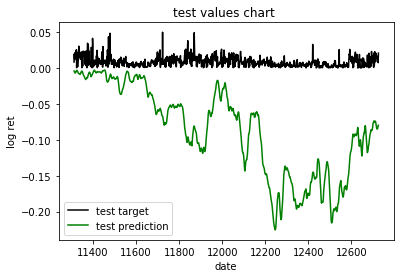

In [19]:
ft = 5

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('test values chart ')
plt.xlabel('date')
plt.ylabel('log ret')
plt.legend(loc='best')



In [131]:
print('mse for training:',mse_train)
print('mse for testing:',mse_test)
print("mse for validation : ",mse_valid)

mse for training: 0.000895469
mse for testing: 0.00869918
mse for validation :  0.00191094


In [ ]:
# options to consider 
# 1. Can straight up add adjacency matrices 


In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf


df = pd.read_csv('4.csv')

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['count'] = min_max_scaler.fit_transform(df['count'].values.reshape(-1,1))
    df['Close Price'] = min_max_scaler.fit_transform(df['Close Price'].values.reshape(-1,1))
    df['edge_count'] = min_max_scaler.fit_transform(df['edge_count'].values.reshape(-1,1))
    df['node_count'] = min_max_scaler.fit_transform(df['node_count'].values.reshape(-1,1))
    df['degree'] = min_max_scaler.fit_transform(df['degree'].values.reshape(-1,1))
    df['transitivity'] = min_max_scaler.fit_transform(df['transitivity'].values.reshape(-1,1))
    df['centrality'] = min_max_scaler.fit_transform(df['centrality'].values.reshape(-1,1))
    df['average_clustering'] = min_max_scaler.fit_transform(df['average_clustering'].values.reshape(-1,1))
    df['number_connected_components'] = min_max_scaler.fit_transform(df['number_connected_components'].values.reshape(-1,1))
    df['density'] = min_max_scaler.fit_transform(df['density'].values.reshape(-1,1))
    df['log_ret'] = min_max_scaler.fit_transform(df['log_ret'].values.reshape(-1,1))
    
    return df



def load_data(stk, seq_len):
    data_raw = stk.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(10/100*data.shape[0]));  
    test_set_size = int(np.round(10/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]




df_norm = normalize_data(df.copy())
seq_len = 50 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)



index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 11
n_neurons = 512 
n_outputs = 11
n_layers = 8
learning_rate = 0.0001
batch_size = 128
n_epochs = 200
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            rmse_train = math.sqrt(loss.eval(feed_dict={X: x_train, y: y_train})) 
            rmse_valid = math.sqrt(loss.eval(feed_dict={X: x_valid, y: y_valid}) )
            rmse_test = math.sqrt(loss.eval(feed_dict={X: x_test, y: y_test}))
            print('%.2f epochs: RMSE train/valid = %.6f/%.6f'%(
                int(iteration*batch_size/train_set_size), rmse_train, rmse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# GridsearchCV not giving any outputs at all , figure out why . 
# implementing denoising autoencoders https://blog.keras.io/building-autoencoders-in-keras.html
# ^ sample code : https://github.com/tgjeon/Keras-Tutorials/blob/master/06_autoencoder.ipynb 


ft = 5
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target',linewidth=4)

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction',linewidth=2)
plt.title('test values chart ')
plt.xlabel('date')
plt.ylabel('log ret')
plt.legend(loc='best')
# plt.rcParams["figure.figsize"] = [20,20]
# plt.show()
plt.savefig("4_1.pdf")


print('RMSE for training:',     rmse_train)
print('RMSE for testing:',      rmse_test)
print("RMSE for validation : ", rmse_valid)



C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\raosa\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel\kernelapp.p

x_train.shape =  (11288, 49, 11)
y_train.shape =  (11288, 11)
x_valid.shape =  (1411, 49, 11)
y_valid.shape =  (1411, 11)
x_test.shape =  (1411, 49, 11)
y_test.shape =  (1411, 11)
